In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from pathlib import Path
import emd

In [2]:
import sys
wdir = Path.cwd().parent.absolute()
sys.path.insert(1, str(wdir))

from preprocess.preprocess_DREAMER import DREAMERDataset
import torch
import os

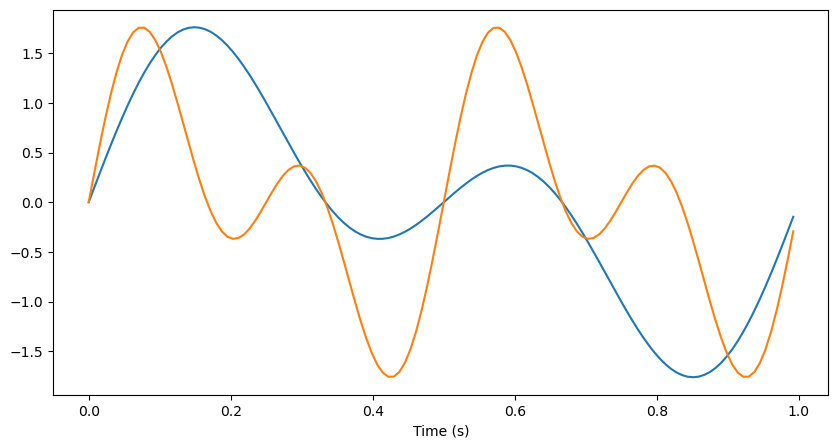

Setting up high-pass filter at 3 Hz

IIR filter parameters
---------------------
butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 3.00 Hz: -6.02 dB



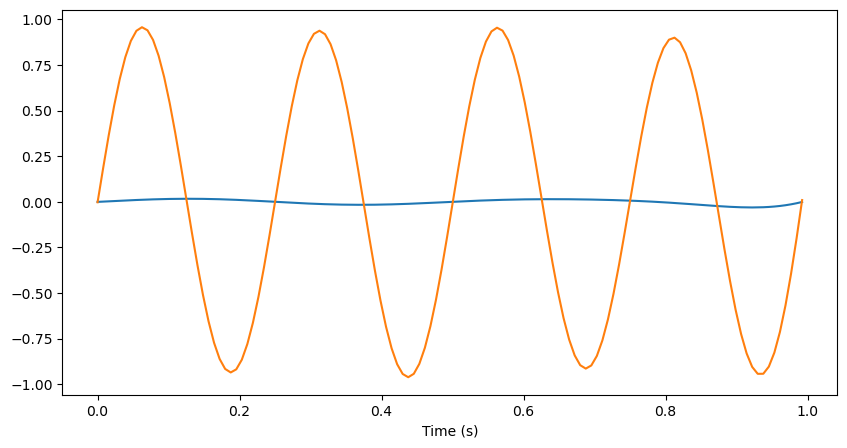

In [3]:
import mne

f = 128
ch = 2
t = np.linspace(0, 1, f, endpoint=False)
signals = [np.sin(2 * np.pi * i * t) + np.sin(2 * np.pi * 2 * i * t) for i in range(1, ch+1)]
signals = np.array(signals)
plt.figure(figsize=(10, 5))
plt.plot(t, signals.T)
plt.xlabel('Time (s)')
plt.show()

low = 3.
high = None
order = 5
filtered_signals = mne.filter.filter_data(signals, f, low, high, 
                                          method='iir', 
                                          iir_params=dict(order=order, ftype='butterworth'), verbose=True)
plt.figure(figsize=(10, 5))
plt.plot(t, filtered_signals.T)
plt.xlabel('Time (s)')
plt.show()

In [4]:
cur_dir = Path.cwd()
path = str(cur_dir.parent.parent) + '/data/DREAMER/'
mat = scipy.io.loadmat(path + 'DREAMER.mat')
print(mat.keys())
print(mat['__header__'])
print(mat['__version__'])
print(mat['__globals__'])

dict_keys(['__header__', '__version__', '__globals__', 'DREAMER'])
b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr 13 17:20:26 2017'
1.0
[]


In [5]:
data, eeg_sr, ecg_sr, eeg_electrodes, n_subjects, n_videos, _, _, _, _  = mat['DREAMER'][0, 0]
eeg_sr = eeg_sr[0, 0]
ecg_sr = ecg_sr[0, 0]
eeg_electrodes = eeg_electrodes[0]
eeg_electrodes = [eeg_electrodes[i][0] for i in range(eeg_electrodes.size)]
n_subjects = n_subjects[0, 0]
n_videos = n_videos[0, 0]
print(data.shape)
print("EEG sampling rate", eeg_sr)
print("ECG sampling rate", ecg_sr)
print("EEG electrodes", eeg_electrodes)
print("Number of subjects", n_subjects)
print("Number of videos", n_videos)

(1, 23)
EEG sampling rate 128
ECG sampling rate 256
EEG electrodes ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
Number of subjects 23
Number of videos 18


In [6]:
age, gender, eeg, ecg, val, aro, dom = data[0, 4][0][0]
age = age[0]
gender = gender[0]
print("Age", age)
print("Gender", gender)
print(val.shape)
print(aro.shape)
print(dom.shape)

Age 27
Gender female
(18, 1)
(18, 1)
(18, 1)


In [7]:
print(val)
labels = (val > 3) * 1
print(labels)

[[4]
 [2]
 [5]
 [1]
 [1]
 [3]
 [4]
 [1]
 [1]
 [3]
 [4]
 [4]
 [4]
 [3]
 [3]
 [3]
 [1]
 [2]]
[[1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


414


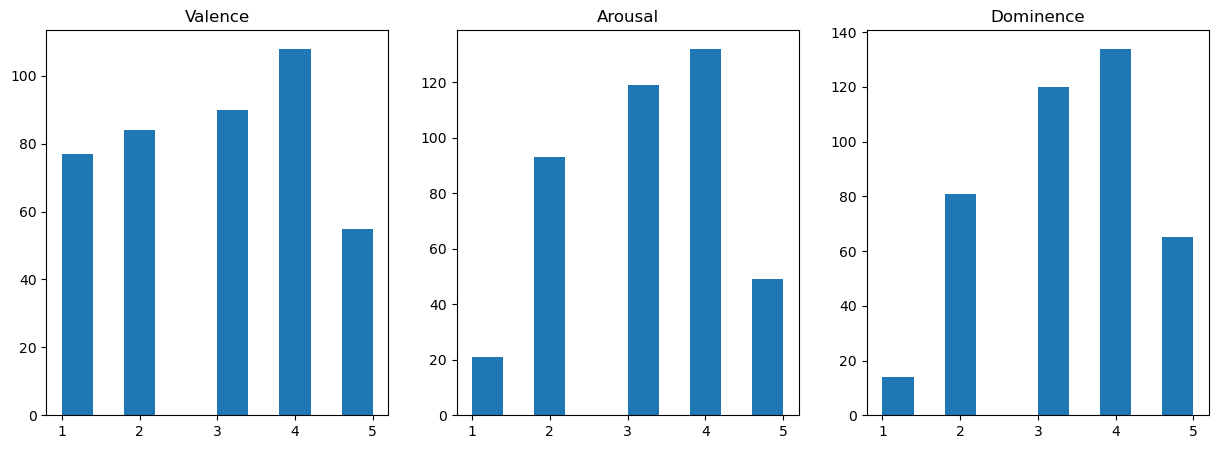

In [8]:
vals = []
aros = []
doms = []
for i in range(n_subjects):
    age, gender, eeg, ecg, val, aro, dom = data[0, i][0][0]
    vals += val.T[0].tolist()
    aros += aro.T[0].tolist()
    doms += dom.T[0].tolist()

print(len(vals))
figs, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(vals)
axes[0].set_title('Valence')
axes[1].hist(aros)
axes[1].set_title('Arousal')
axes[2].hist(doms)
axes[2].set_title('Dominence')
plt.show()

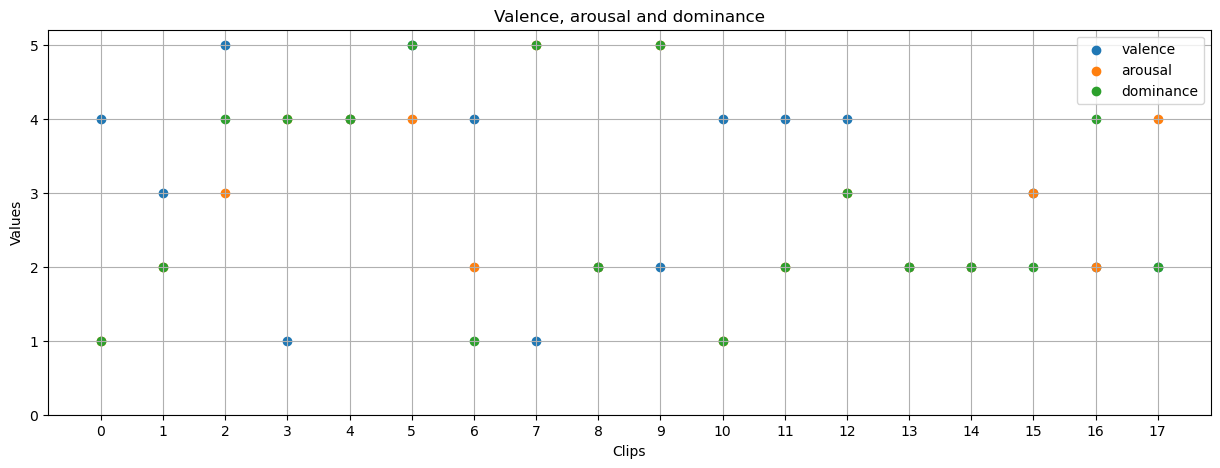

In [9]:
x = np.arange(0, val.shape[0])
y = np.arange(0, np.max(np.concatenate((val, aro, dom), axis=0))+1)

plt.figure(figsize=(15, 5))
plt.scatter(x, val, label='valence')
plt.scatter(x, aro, label='arousal')
plt.scatter(x, dom, label='dominance')
plt.xlabel('Clips')
plt.xticks(x)
plt.ylabel('Values')
plt.yticks(y)
plt.title('Valence, arousal and dominance')
plt.grid()
plt.legend()
plt.show()

In [10]:
baseline_eeg, stimuli_eeg = eeg[0, 0]
baseline_ecg, stimuli_ecg = ecg[0, 0]
print(baseline_eeg.shape)
print(stimuli_eeg.shape)
print(baseline_ecg.shape)
print(stimuli_ecg.shape)

(18, 1)
(18, 1)
(18, 1)
(18, 1)


(7808, 14)
(25472, 14)
(15616, 2)
(50944, 2)


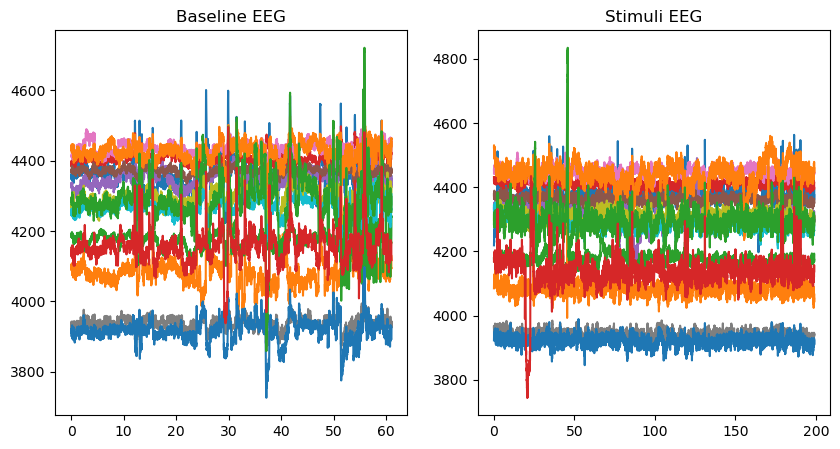

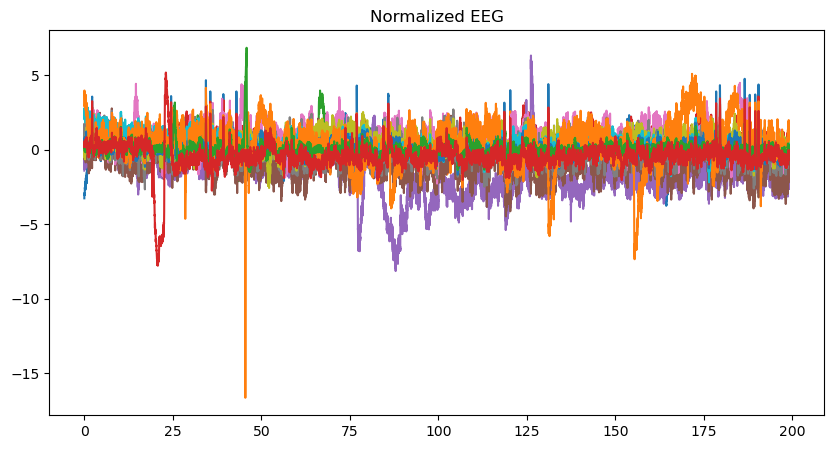

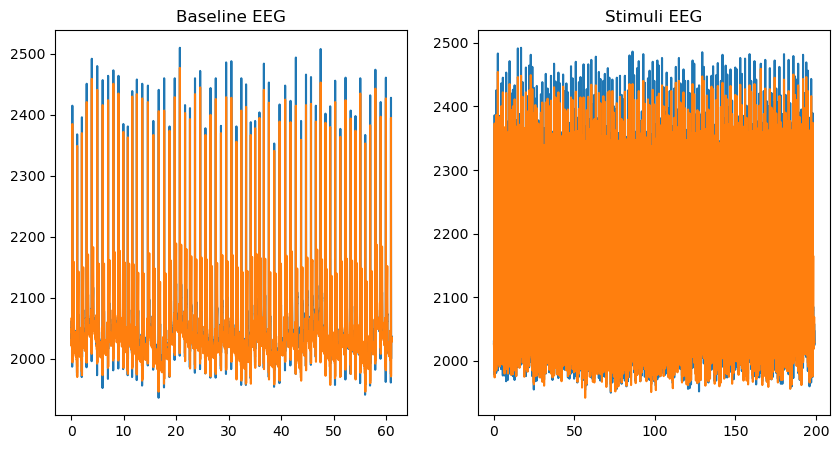

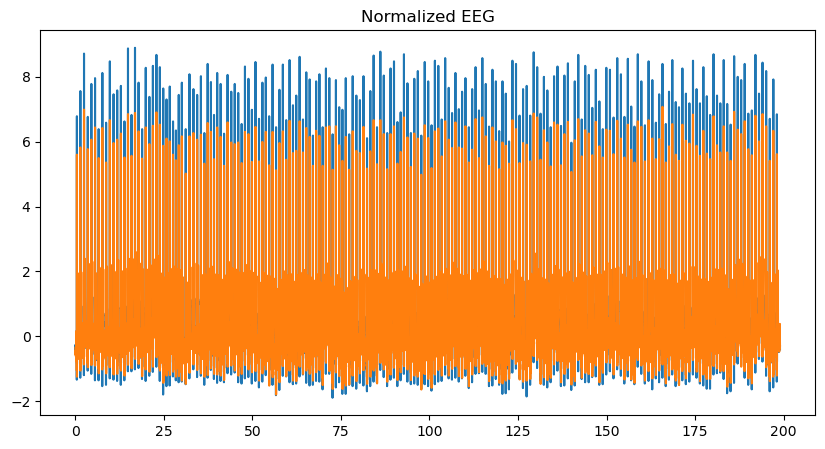

In [11]:
baseline_eeg1 = baseline_eeg[0, 0]
stimuli_eeg1 = stimuli_eeg[0, 0]
baseline_ecg1 = baseline_ecg[0, 0]
stimuli_ecg1 = stimuli_ecg[0, 0]
print(baseline_eeg1.shape)
print(stimuli_eeg1.shape)
print(baseline_ecg1.shape)
print(stimuli_ecg1.shape)


time1 = np.arange(baseline_eeg1.shape[0]) / eeg_sr
time2 = np.arange(stimuli_eeg1.shape[0]) / eeg_sr
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(time1, baseline_eeg1)
plt.title('Baseline EEG')
plt.subplot(1, 2, 2)
plt.plot(time2, stimuli_eeg1)
plt.title('Stimuli EEG')
plt.show()

normalized_eeg = stimuli_eeg1 - np.mean(baseline_eeg1, axis=0)
normalized_eeg = normalized_eeg / np.std(baseline_eeg1, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(time2, normalized_eeg)
plt.title('Normalized EEG')
plt.show()

time1 = np.arange(baseline_ecg1.shape[0]) / ecg_sr
time2 = np.arange(stimuli_ecg1.shape[0]) / ecg_sr
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(time1, baseline_ecg1)
plt.title('Baseline EEG')
plt.subplot(1, 2, 2)
plt.plot(time2, stimuli_ecg1)
plt.title('Stimuli EEG')
plt.show()

normalized_ecg = stimuli_ecg1 - np.mean(baseline_ecg1, axis=0)
normalized_ecg = normalized_ecg / np.std(baseline_ecg1, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(time2, normalized_ecg)
plt.title('Normalized EEG')
plt.show()

In [12]:
for i in range(n_videos):
    s = stimuli_eeg[i, 0]
    print(s.shape[0]/eeg_sr)
    

199.0
131.0
348.0
166.0
136.0
190.0
192.0
394.0
145.0
67.0
96.0
181.0
368.0
170.0
308.0
195.0
256.0
186.0


In [13]:
test = baseline_eeg1.T
test = test.reshape(-1, test.shape[0], eeg_sr).mean(axis=0)
test.shape

(14, 128)

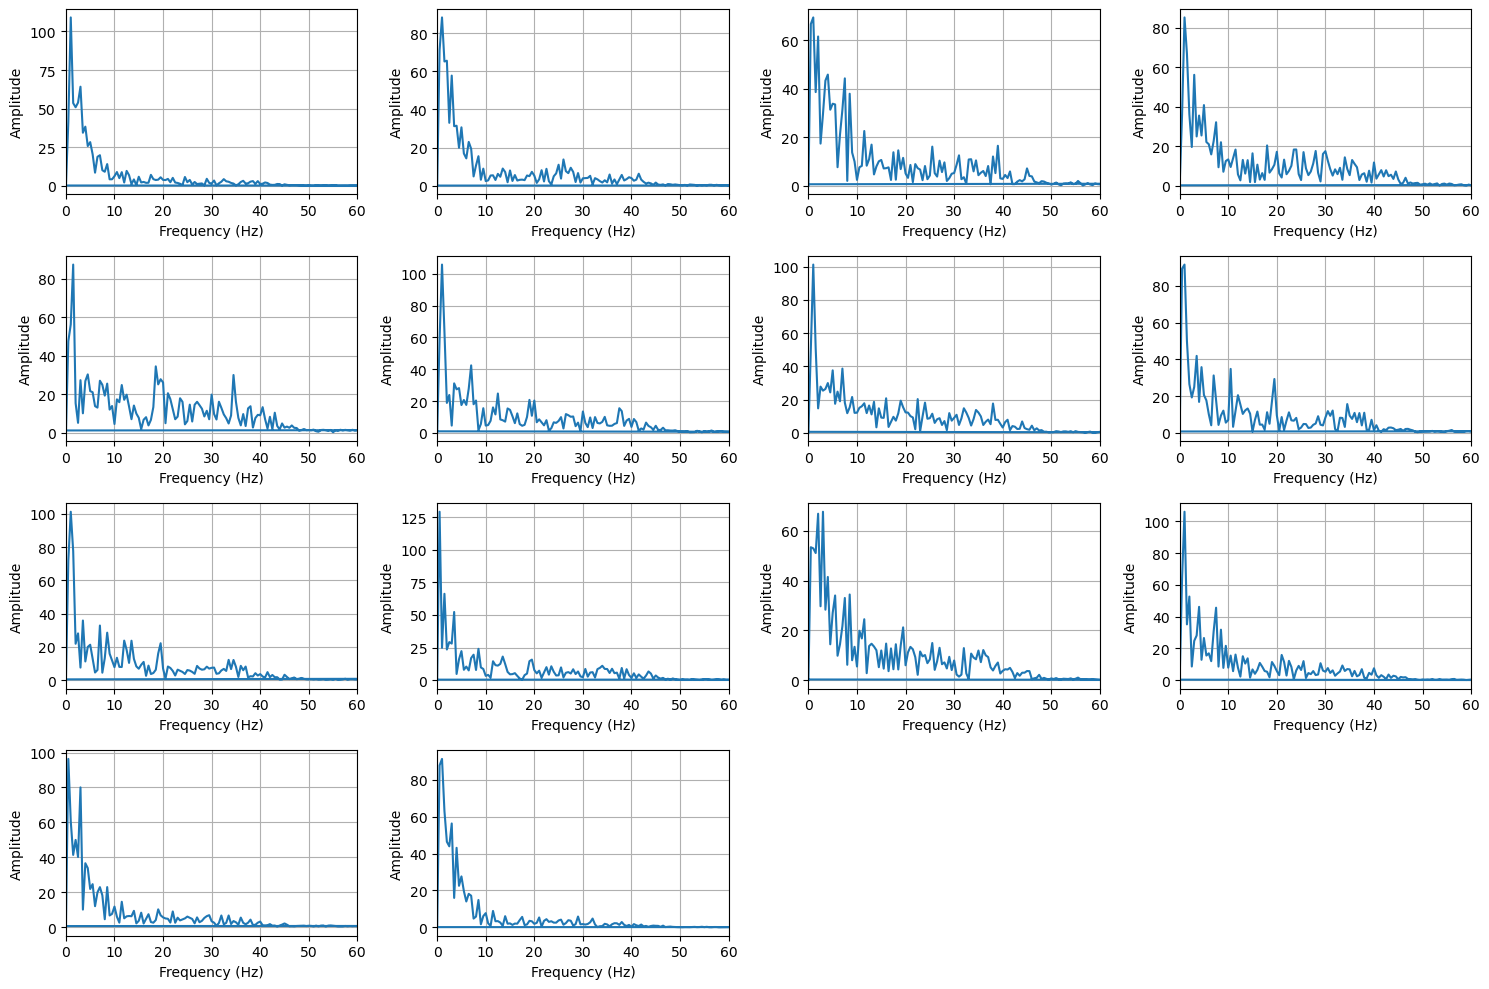

In [14]:
plt.figure(figsize=(15, 10))
for i in range(stimuli_eeg1.shape[1]):
    s = stimuli_eeg1[256:512, i]
    b = baseline_eeg1[:, i]
    s = s - np.mean(s)
    s = s / np.std(s)
    fft_result = fft(s)

    # Calculate the frequencies corresponding to the FFT result
    frequencies = fftfreq(len(s), 1 / eeg_sr)
    # Plot the frequency spectrum
    plt.subplot(4, 4, i+1)
    plt.plot(frequencies, np.abs(fft_result))
    plt.xlabel('Frequency (Hz)')
    plt.xlim([0, 60])
    plt.ylabel('Amplitude')
    plt.grid(True)
plt.tight_layout()
plt.show()

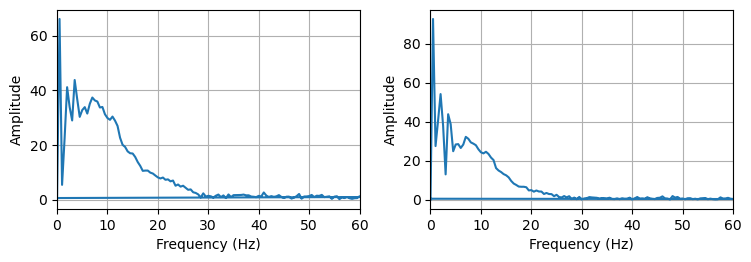

In [15]:
plt.figure(figsize=(15, 10))
for i in range(stimuli_ecg1.shape[1]):
    s = stimuli_ecg1[256:512, i]
    b = baseline_ecg1[:, i]
    s = s - np.mean(s)
    s = s / np.std(s)
    fft_result = fft(s)

    # Calculate the frequencies corresponding to the FFT result
    frequencies = fftfreq(len(s), 1 / eeg_sr)
    # Plot the frequency spectrum
    plt.subplot(4, 4, i+1)
    plt.plot(frequencies, np.abs(fft_result))
    plt.xlabel('Frequency (Hz)')
    plt.xlim([0, 60])
    plt.ylabel('Amplitude')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
test = normalized_eeg.T
res = [emd.sift.sift(test[i], max_imfs=8) for i in range(test.shape[0])]
print(len(res))
for i in range(len(res)):
    print(res[i].shape)


14
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
(25472, 9)
